In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Flatten,
    Dense,
)
from keras.utils import to_categorical
from keras import Model

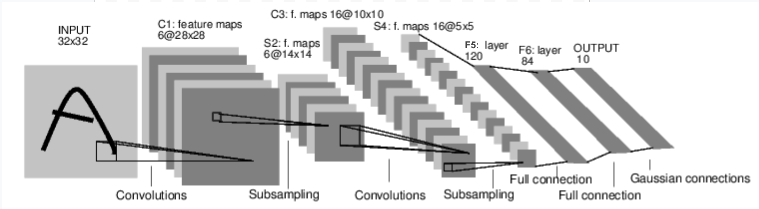

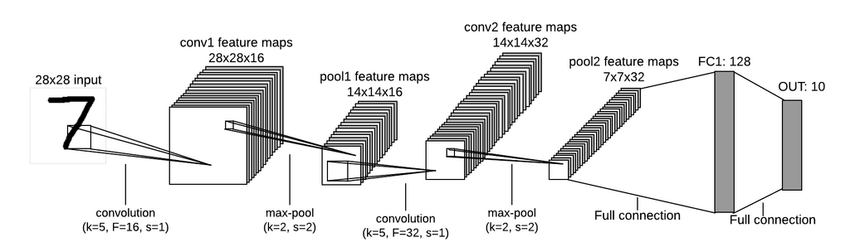

# <ins>Illustration for 3×3 kernel, single input and single output channel<ins>

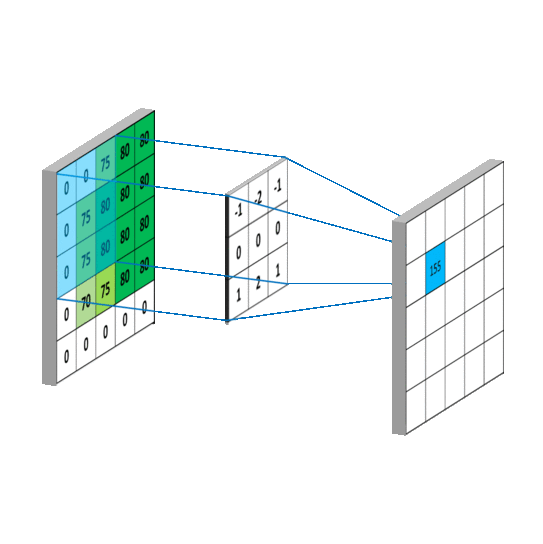

# <ins>Illustration for 3×3 kernel, padding 1, stride 2, three input and two output channels<ins>

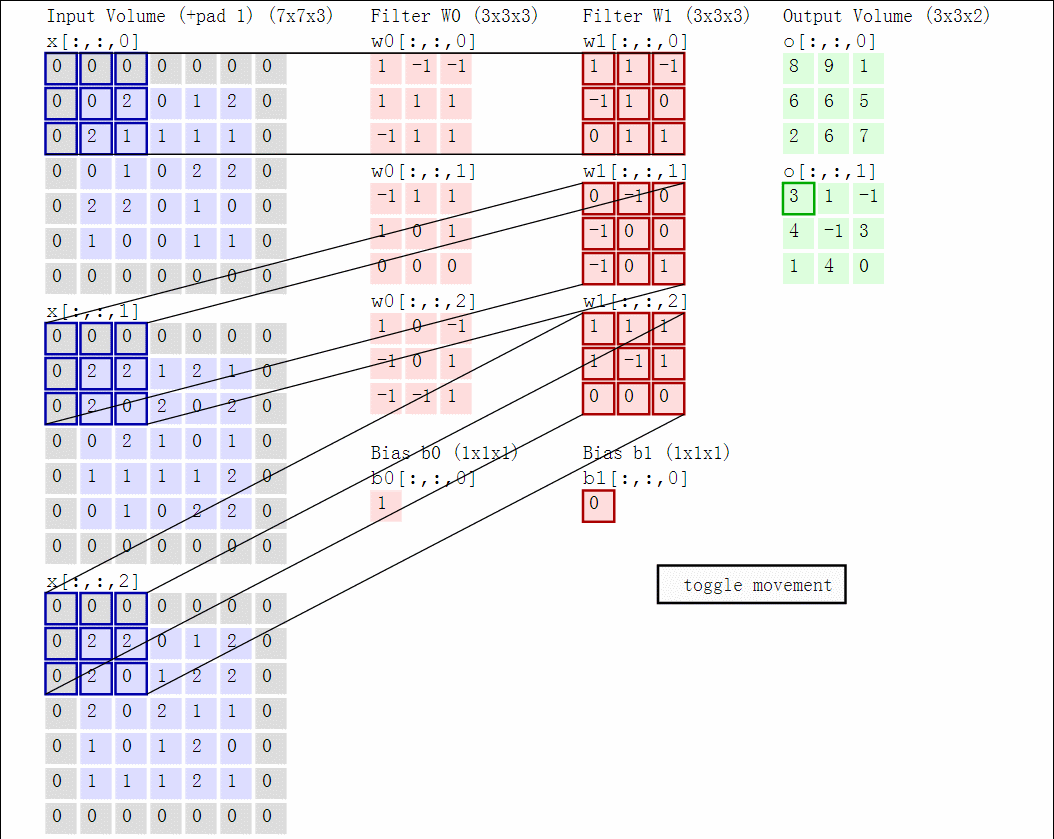

In [2]:
from IPython.display import Image, display, Markdown

cnn_image_path = "../../images/cnn.png"
display(Image(filename=cnn_image_path))

cnn2_image_path = "../../images/cnn2.png"
display(Image(filename=cnn2_image_path))

display(
    Markdown(
        f"# <ins>Illustration for 3×3 kernel, single input and single output channel<ins>"
    )
)
singlechannel_cnn_image_path = "../../images/singlechannel-conv.gif"
display(Image(filename=singlechannel_cnn_image_path))

display(
    Markdown(
        f"# <ins>Illustration for 3×3 kernel, padding 1, stride 2, three input and two output channels<ins>"
    )
)
multichannel_cnn_image_path = "../../images/multichannel-conv.gif"
display(Image(filename=multichannel_cnn_image_path))

$$ \underline{\text{Convolution}} $$
$$ \text{Conv}(x, w)_{i,j} = \sum_m \sum_n x_{i+m,j+n} \cdot w_{m,n} $$

$$ \underline{\text{Output Feature Map Size}} $$
$$ W_{out} = floor((W_{in} - K + 2P) / S) + 1 $$

$$ H_{out} = floor((H_{in} - K + 2P) / S) + 1 $$

$$ C_{out} = N_f \text{ OR } F $$

- $ x $ : Input feature map
- $ w $ : Convolutional kernel of size K $(0 \leq m, n \leq K-1)$
- $ i, j $ : Spatial position in the output feature map
- $ C_{out} $ : Number of output channels
- $ N_f $ OR $ F $ : Number of filters (kernels)
- $ W_{out} $ : Width of the output feature map after convolution
- $ H_{out} $ : Height of the output feature map after convolution
- $ W_{in} $ : Width of the input feature map
- $ H_{in} $ : Height of the input feature map
- $ K $ : Size of the convolutional kernel (both width and height for a square kernel)
- $ P $ : Padding added to the input feature map
- $ S $ : Stride, the step size at which the convolutional kernel moves over the input

$$ \underline{\text{Max-Pooling}} $$
$$
\text{maxpool}(X, k, s)_{i,j} = \max_{p=0}^{k-1} \max_{q=0}^{k-1} X_{i \cdot s + p, j \cdot s + q}
$$

$$ \underline{\text{Output Feature Map Size}} $$
$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2P - k}{s} \right\rfloor + 1
$$
$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2P - k}{s} \right\rfloor + 1
$$
$$
C_{\text{out}} = C_{\text{in}}
$$

- $ X $ : Input matrix or tensor
- $ k $ : Window size (also known as the kernel size) for pooling
- $ s $ : Stride, which is the step size at which the pooling window moves
- $ i, j $ : Indices of the output element in the pooled matrix

In [ ]:
class CNN(keras.Model):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()

        # filters (int): Dimensionality of the output space (i.e. the number of output filters in the convolution).
        #                Equivalent to out_channels in PyTorch.
        # kernel_size (int/tuple): Specifies the height and width of the 2D convolution window.
        #                          Can be a single integer to specify the same value for all spatial dimensions.
        # strides (int/tuple): Specifies the strides of the convolution along the height and width.
        #                      Can be a single integer to specify the same value for all spatial dimensions.
        #                      Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
        # padding (str): one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with
        #                zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output
        #                has the same size as the input.
        self.conv1 = Conv2D(
            filters=32, kernel_size=3, strides=1, padding="same", activation=None
        )
        self.batchnorm1 = BatchNormalization()
        self.relu1 = ReLU()
        self.pool1 = MaxPooling2D(pool_size=2, strides=2)

        self.conv2 = Conv2D(
            64, kernel_size=3, strides=1, padding="same", activation=None
        )
        self.batchnorm2 = BatchNormalization()
        self.relu2 = ReLU()
        self.pool2 = MaxPooling2D(pool_size=2, strides=2)

        self.flatten = Flatten()
        self.fc1 = Dense(512, activation=None)
        self.batchnorm_fc = BatchNormalization()
        self.relu_fc = ReLU()
        self.fc2 = Dense(num_classes)

    def call(self, inputs):
        x = self.pool1(self.relu1(self.batchnorm1(self.conv1(inputs))))
        x = self.pool2(self.relu2(self.batchnorm2(self.conv2(x))))
        x = self.flatten(x)
        x = self.fc2(self.relu_fc(self.batchnorm_fc(self.fc1(x))))
        return x

    def train_model(
        self, train_data, train_labels, num_epochs=100, learning_rate=0.001
    ):
        # Define loss function and optimizer
        criterion = keras.losses.CategoricalCrossentropy(from_logits=True)
        optimizer = keras.optimizers.Adam(learning_rate)

        for epoch in range(num_epochs):
            # Convert data to TensorFlow tensors
            inputs = tf.constant(train_data, dtype=tf.float32)
            labels = tf.constant(train_labels, dtype=tf.int64)

            # Forward pass
            with tf.GradientTape() as tape:
                outputs = self(inputs)
                loss = criterion(labels, outputs)

            # Backward and optimize
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            if (epoch + 1) % 1 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")

    def predict(self, input_data):
        # Make predictions for input_data
        predictions = self(input_data)
        return tf.argmax(predictions, axis=1).numpy()

In [ ]:
# Generate synthetic training data for TensorFlow
num_samples = 100
image_height = 32
image_width = 32
input_channels = 3
num_classes = 10

train_data = tf.random.normal((num_samples, image_height, image_width, input_channels))
train_labels = to_categorical(
    tf.random.uniform((num_samples,), minval=0, maxval=num_classes, dtype=tf.int64),
    num_classes=num_classes,
)

# Displaying the shape of the generated data (optional)
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)

# Example usage for TensorFlow:
model_cnn = CNN(input_channels=input_channels, num_classes=num_classes)
model_cnn.train_model(train_data, train_labels)

# Example test data
test_data_cnn = tf.random.normal((1, image_height, image_width, input_channels))

# Make predictions with TensorFlow model
predictions_cnn = model_cnn.predict(test_data_cnn)
print(
    "Predictions (CNN):", predictions_cnn
)  # In TensorFlow, represents the class index directly